In [1]:
import torch
import sys
import torch
import os.path as osp
import tqdm
import sys
import numpy as np
sys.path.append('/afs/cern.ch/work/m/mgarciam/private/mlpf/')
from src.dataset.dataset import SimpleIterDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
import dgl


/afs/cern.ch/work/m/mgarciam/private/miniconda/miniconda3/envs/graphgps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor(8.4853)

In [2]:
class Args:
    def __init__(self):
        self.data_train = ['/afs/cern.ch/work/m/mgarciam/public/mlpf_250723/pf_tree_1.root']
        self.data_val = ['/afs/cern.ch/work/m/mgarciam/public/mlpf_250723/pf_tree_1.root']
        #self.data_train = files_train
        self.data_config = '/afs/cern.ch/work/m/mgarciam/private/mlpf/config_files/config_2_newlinks.yaml'
        self.extra_selection = None
        self.train_val_split = 0.8
        self.data_fraction = 1
        self.file_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.steps_per_epoch = None
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.no_remake_weights = False
        self.batch_size = 10
        self.num_workers = 0
        self.demo = False
        self.laplace = False
        self.diffs = False
        self.class_edges = False
args = Args()
train_range = (0, args.train_val_split)
train_file_dict, train_files = to_filelist(args, 'train')

In [3]:
train_data = SimpleIterDataset(train_file_dict, args.data_config, for_training=True,
                                   extra_selection=args.extra_selection,
                                   remake_weights= True,
                                   load_range_and_fraction=(train_range, args.data_fraction),
                                   file_fraction=args.file_fraction,
                                   fetch_by_files=args.fetch_by_files,
                                   fetch_step=args.fetch_step,
                                   infinity_mode= False,
                                   in_memory=args.in_memory,
                                   async_load = False,
                                   name='train')

In [4]:
iterator = iter(train_data)

=== Restarting DataIter train, seed=None ===


In [5]:

g, y = next(iterator)

In [6]:
print(np.unique(g.ndata['particle_number']))
print(y.shape)

[1. 2. 3. 4.]
torch.Size([4, 7])


In [7]:
from src.dataset.functions_graph import graph_batch_func

train_loader = DataLoader(train_data, batch_size=10, drop_last=True, pin_memory=True,
                          num_workers=min(args.num_workers, int(len(train_files) * args.file_fraction)),
                          collate_fn=graph_batch_func,
                          persistent_workers=args.num_workers > 0 and args.steps_per_epoch is not None)
iterator = iter(train_loader)
g, y = next(iterator)



=== Restarting DataIter train, seed=None ===


In [44]:
from src.models.wrapper.example_gravnet_model import GraphTransformerNetWrapper
model = GraphTransformerNetWrapper('cpu', output_dim=30)
model.load_state_dict(torch.load('/eos/user/g/gkrzmanc/mlpf_data/25_07_2023/_epoch-48_state.pt', map_location='cpu'))


<All keys matched successfully>

In [45]:
pred = model(g)

In [46]:

print(pred.shape)
_, S = pred.shape
xj = pred[:, 0:2]  # 0, 1, 2: cluster space coords
bj = torch.sigmoid(torch.reshape(pred[:, 2], [-1, 1])) 
xj =xj.detach().numpy()


torch.Size([5745, 30])


In [53]:
q_graph.view(-1).detach().numpy()

array([0.102176  , 1.8839972 , 0.10176648, 2.0565233 , 0.1000687 ,
       0.10006411, 0.10003785, 0.10007431, 0.10007372, 0.10006487,
       0.10007568, 0.10006412, 0.10005211, 0.10007101, 0.10007303,
       0.10002773, 0.10007218, 0.10007442, 0.10007561, 0.1000744 ,
       0.10006675, 0.10006808, 0.1000716 , 0.10004532, 0.10007198,
       0.10006832, 0.10007749, 0.10007243, 0.10007559, 0.10007364,
       0.10006899, 0.1000645 , 0.10006908, 0.10007387, 0.10006872,
       0.1000604 , 0.10006474, 0.10002226, 0.10743641, 0.10013731,
       0.10006744, 0.1000162 , 0.1000337 , 0.10012265, 0.10000643,
       0.17998028, 0.1000078 , 0.6036223 , 0.10004622, 0.10005044,
       0.1000935 , 0.10035552, 0.10014781, 0.10009513, 0.10022495,
       0.10028248, 0.10000769, 0.1000486 , 0.10004858, 0.10002813,
       0.10002911, 0.10003211, 0.10002358, 0.10007913, 0.1001341 ,
       0.10001829, 0.10000829, 0.10010145, 0.10003511, 0.10005981,
       0.10002246, 0.10006209, 0.10000675, 0.10004405, 0.10005

In [55]:
q_alpha

tensor([0.0000, 0.1001, 0.1001, 2.0565], grad_fn=<CppNode<ScatterMax>>)

In [47]:
q = bj.arctanh() ** 2 + 0.1

In [71]:
g

Graph(num_nodes=5745, num_edges=40215,
      ndata_schemes={'h': Scheme(shape=(9,), dtype=torch.float32), 'pos_hits': Scheme(shape=(3,), dtype=torch.float32), 'pos_hits_norm': Scheme(shape=(3,), dtype=torch.float32), 'hit_type': Scheme(shape=(4,), dtype=torch.int64), 'p_hits': Scheme(shape=(1,), dtype=torch.float32), 'e_hits': Scheme(shape=(1,), dtype=torch.float32), 'particle_number': Scheme(shape=(), dtype=torch.float32), 'particle_number_nomap': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={})

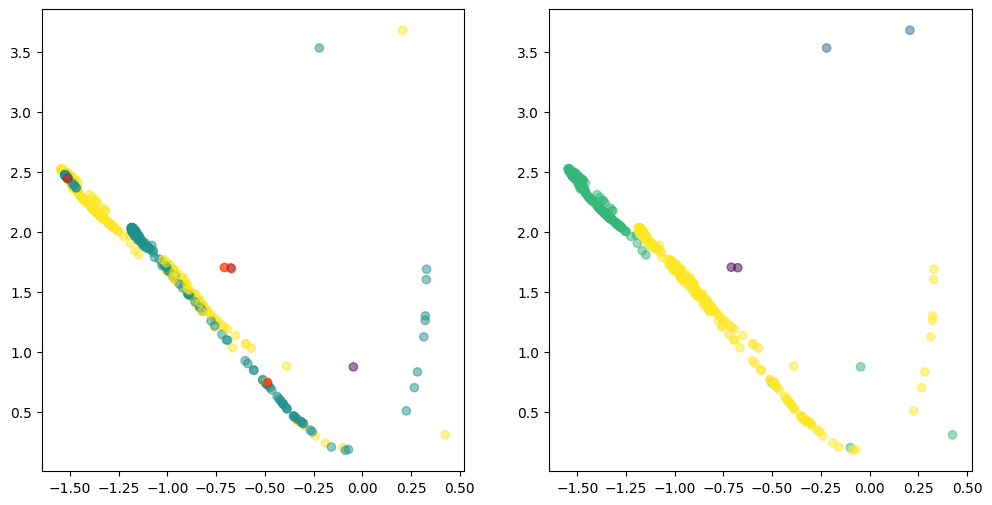

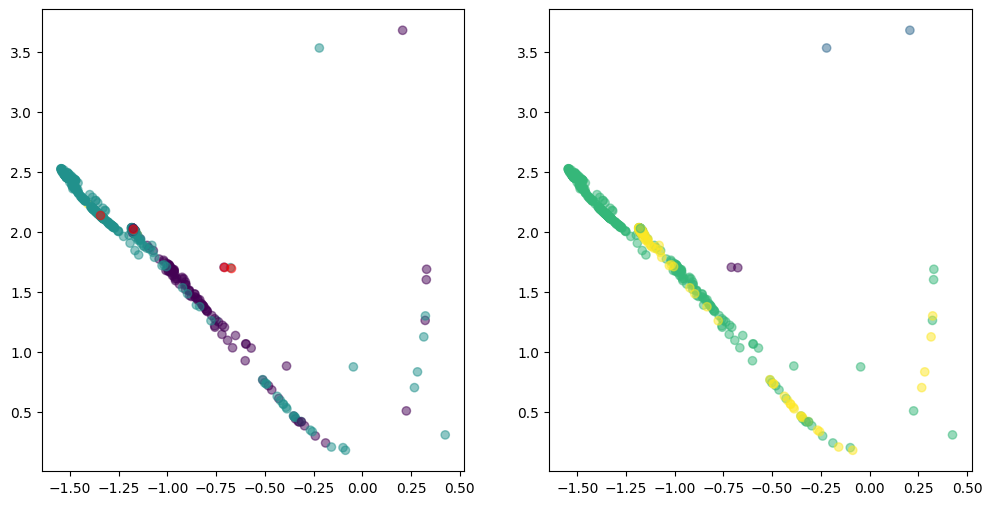

In [94]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_scatter import scatter_max, scatter_add, scatter_mean
graph_list = dgl.unbatch(g)
node_counter = 0

how_many_to_plot = 2
for i in range(0, how_many_to_plot):
    graph_eval = graph_list[i]
    non = graph_eval.number_of_nodes()
    particle_number = graph_eval.ndata['particle_number']-1
    q_graph = q[node_counter:node_counter+non]
    hit_type = torch.argmax(graph_eval.ndata['hit_type'],dim=1).view(-1)
    q_alpha, index_alpha = scatter_max(q_graph.view(-1), graph_eval.ndata['particle_number'].view(-1).to(torch.long))
    xj_graph = xj[node_counter:node_counter+non,:]
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].scatter(xj_graph[:,0],xj_graph[:,1], c =graph_eval.ndata['particle_number'], alpha=0.5)
    axs[0].scatter(xj_graph[index_alpha-1][:,0],xj_graph[index_alpha-1][:,1], marker='o', c ="r", alpha=0.5)
    axs[1].scatter(xj_graph[:,0],xj_graph[:,1], c =hit_type, alpha=0.5, vmin=0, vmax=3)
    pos = graph_eval.ndata['pos_hits_norm']




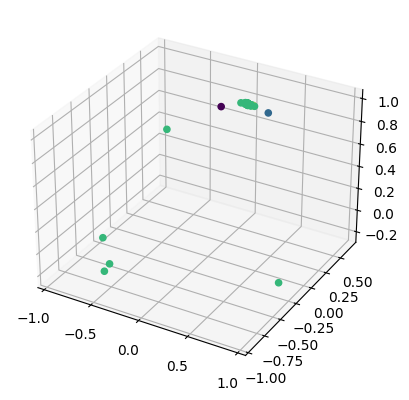

In [100]:
i = 1
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
particle_id = graph_eval.ndata['particle_number'].view(-1)
ax.scatter(pos[:,0][particle_id==i], pos[:,1][particle_id==i], pos[:,2][particle_id==i],marker='o', c = hit_type[particle_id==i], alpha=1)

In [97]:
np.unique(particle_id)

array([1., 2., 3.], dtype=float32)

In [99]:
hit_type[particle_id==i]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3])